Я выбрал тему NST, так как все ресурсы заняты под обучение edvanced super resultion GAN, которую я выбрал как нейросеть для проекта. Кроме того, так как GAN выбран для проекта, хотелось бы в домашней работе посмотреть что-то другое.

In [1]:
!pip3 install torch torchvision
!pip3 install pillow

In [2]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

## Класс для загрузки изображений

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Images:

    def __init__(self, content, style1, style2, size = 128):
      self.transorms = transforms.Compose([
          transforms.Resize(size),
          transforms.CenterCrop(size),
          transforms.ToTensor()])

      self.style1 = self.image_loader(style1)
      self.style2 = self.image_loader(style2)
      self.content = self.image_loader(content)

    def image_loader(self, image_name):
      
      image = Image.open(image_name)
      image = self.transorms(image).unsqueeze(0)
      return image.to(device, torch.float)

In [4]:
images = Images("content.jpg", "style1.jpg", "style2.jpg")

Выведем то, что было загружено

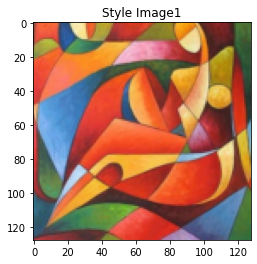

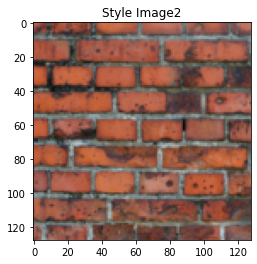

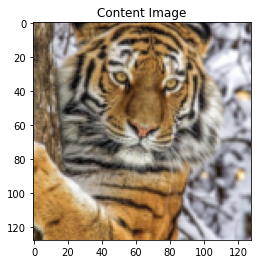

In [5]:
unloader = transforms.ToPILImage()

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)     
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
imshow(images.style1, title='Style Image1')

plt.figure()
imshow(images.style2, title='Style Image2')

plt.figure()
imshow(images.content, title='Content Image')

Теперь нужно создать функции, которые будут вычислять расстояния ( $D_C$ и $D_S$). <br />
Они будут выполенены в виде слоев, чтобы брать по ним автоградиент.

$D_S$ - средняя квадратичная ощибка input'а и target'а

In [6]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target)#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

Перенос двух стилей по маске. Мы создаем маски: прямую и инверсную, разделенные главной диагональю. Мы считаем матрицы Грама только по половине входного фичемапа, заполняя остальное нулями. В результате, две матрицы Грама для двух стилей, мы подаем в mse_loss(), вычисляя mse метрику с таргетом для каждой из них. Итоговый лосс будет суммой двух полученных лоссов.

In [7]:
import numpy as np

class StyleLoss(nn.Module):
        def __init__(self, target_feature1, target_feature2):
            super(StyleLoss, self).__init__()
            self.target1 = self.gram_matrix(target_feature1).detach()
            self.mask1 = self.createMask_(target_feature1)
            self.target2 = self.gram_matrix(target_feature2).detach()
            self.mask2 = 1 - self.mask1
            self.loss = F.mse_loss(self.target1, self.target1)# to initialize with something

        def forward(self, input):
            G1 = self.gram_matrix(input * self.mask1)
            G2 = self.gram_matrix(input * self.mask2)
            self.loss = F.mse_loss(G1, self.target1) + F.mse_loss(G2, self.target2)
            return input

        def createMask_(self, t):
            result = np.ones_like(t.numpy())
            result = np.triu(result)
            return torch.from_numpy(result)

        def gram_matrix(self, input):
            batch_size , h, w, f_map_num = input.size()
            features = input.view(batch_size * h, w * f_map_num)
            G = torch.mm(features, features.t())
            return G.div(batch_size * h * w * f_map_num)

Помимо Style и Content лоссов, я добавил так же TotalVariationLoss. Это регуляризационный лосс. Он штрафует модель за слишком большую разницу между соседними пикселями, снижая таким образом шумность результирующего изображения. Вычисляется он просто -- как среднее значение разности между соседними пикселями фичемапа

In [8]:
class TotalVariationLoss(nn.Module):
    def __init__(self):
      super(TotalVariationLoss, self).__init__()
      self.loss = 1

    def forward(self, input):
      self.loss = torch.mean(torch.abs(input[:, :, :, :-1] - input[:, :, :, 1:])) + torch.mean(torch.abs(input[:, :, :-1, :] - input[:, :, 1:, :]))
      return input

Не забываем про нормализацию цветов с коэффиентами, которые были применены при обучении VGG19 на ImageNet


In [9]:
class Normalization(nn.Module):
        def __init__(self):
            super(Normalization, self).__init__()
            self.register_buffer(
                'mean',
                torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
            self.register_buffer(
                'std',
                torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

        def forward(self, img):
            return (img - self.mean) / self.std

In [10]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Встроим в VGG19 лоссы для контента, стиля, а так же total variation лосс

In [11]:
def get_style_model_and_losses(cnn, style_img1, style_img2, content_img,
                                   content_layers=['conv_4'],
                                   style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization().to(device)

        # just in order to have an iterable access to or list of content/syle/tv
        # losses
        content_losses = []
        style_losses = []
        tv_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature1 = model(style_img1).detach()
                target_feature2 = model(style_img2).detach()
                style_loss = StyleLoss(target_feature1, target_feature2)
                tv_loss = TotalVariationLoss()
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)
                # to every style loss layer add TV regularization loss
                model.add_module("tv_loss_{}".format(i), tv_loss)
                tv_losses.append(tv_loss)

        # now we trim off the layers after the last content and style losses
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses, tv_losses

Дефолтный learning rate слишком большой. Уменьшим его до 0.05, иначе картинка будет слишком резкая и пиксели будут часто попадать в область отрицательных значений, что будет вносить цветной шум в результирующую картинку.

In [12]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()], lr=0.05) 
        return optimizer

Запускаем перенос стиля. Данный цикл фактически оптимизирует единственный тензор, который является входным изображением.

In [13]:
def run_style_transfer(cnn, content_img, style_img1, style_img2, input_img, num_steps=300,
                        style_weight=10000, content_weight=1, tv_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses, tv_losses = get_style_model_and_losses(cnn, style_img1, style_img2, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0.05, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0
                tv_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                for tvl in tv_losses:
                    tv_score += tvl.loss
                
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight
                tv_score *= tv_weight

                loss = style_score + content_score + tv_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f} TotalVariation Loss: {:4f}'.format(
                        style_score.item(), content_score.item(), tv_score.item()))
                    print()

                    plt.figure()
                    input_img.data.clamp_(0, 1)
                    imshow(input_img, title='input_img Image')
                    plt.ioff()
                    plt.show()

                return style_score + content_score + tv_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Посмотрим, как картинка медленно, но верно будет менять свой облик...

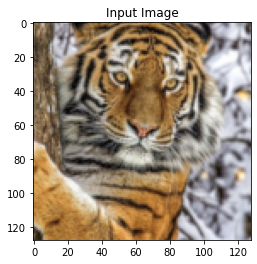

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 278.361816 Content Loss: 23.785954 TotalVariation Loss: 24.930979



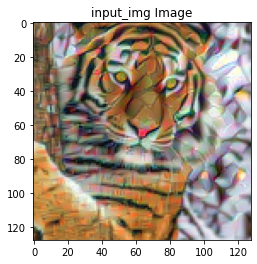

run [100]:
Style Loss : 162.365021 Content Loss: 32.658981 TotalVariation Loss: 25.339172



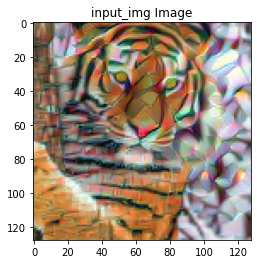

run [150]:
Style Loss : 108.170441 Content Loss: 38.557526 TotalVariation Loss: 25.008663



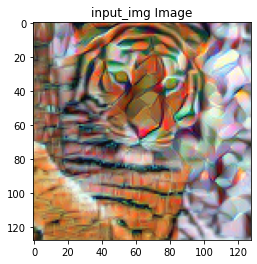

run [200]:
Style Loss : 75.842033 Content Loss: 42.852791 TotalVariation Loss: 24.927017



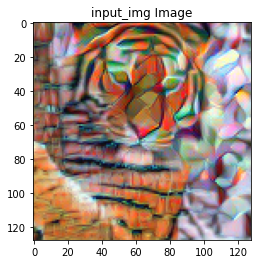

run [250]:
Style Loss : 55.109680 Content Loss: 45.540279 TotalVariation Loss: 24.789875



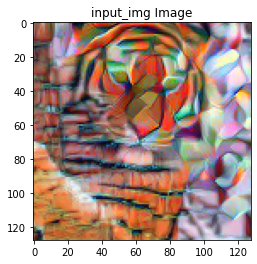

run [300]:
Style Loss : 43.058395 Content Loss: 46.744534 TotalVariation Loss: 24.639412



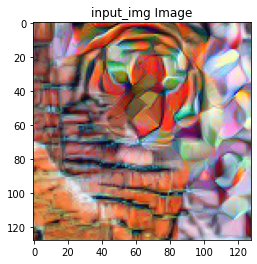

In [14]:
input_img = images.content.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, images.content, images.style1, images.style2, input_img)

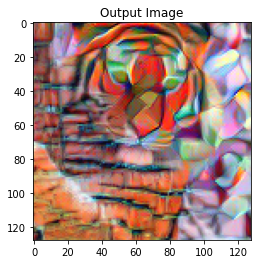

In [15]:
plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()

Мы получили результирующую картинку с применением двух стилей, разделенных главной диагональю. 